In [172]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold,
)

import opendatasets as od
import numpy as np
import pandas as pd
np.random.seed(42)

from yellowbrick.model_selection import LearningCurve
import plotly.express as px

import string
import time
import re

import nltk
from nltk.corpus import stopwords

from natasha import Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger, Doc
import optuna

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# <hr><p align='center' style='color: #6c89c6;'>Работу выполнил: Таратин Артём ПМ22-1<br> Датасет: [Russian Social Media Text Classification](https://www.kaggle.com/datasets/mikhailma/russian-social-media-text-classification)</p>

## <hr>Введение

На данный момент машинное обучение играет ключевую роль в обработке больших данных в задачах обработки естественного языка, в том числе и распознавании тем текстов. Способность алгоритмов эффективно выполнять человеческую работу в этой сфере открывает новые горизонты для большого количества сфер деятельности.

Проблемой исследования является достижение хороших показателей метрик в данной задаче, что в силу многообразия языковых конструкций является довольно непростой задачей.

Я постараюсь раскрыть тему классификации текстов с предобработкой датасета и применением различных способов, моделей машинного обучения.

В работе используются методы векторизации текста `TF-IDF` и различные модели из python библиотеки `scikit-learn`.

Работа поможет понять теоретическую часть механизмов классификации текстов, а также продемонстрирует их применение. Разработанные методы смогут найти применение в любых других задачах, связанных с классификацией текстов.

## <hr>**Глава 1. Основа**

### 1.1 Введение в NLP и классификацию текстов

NLP (Natural Language Processing) - Обработка естественного языка это направление в машинном обучении, фокусирующееся на обработке, распознавании и генерации текста для различного рода задач. NLP тесно связяна не только с машинным мбучением, но и с лингвистикой.

На данный момент, NLP используется повсюду: Chat GPT, YandexGPT, поиск в Яндексе, Google, персональный помощник Алиса, Маруся и т.п. Такой подход позволяет значительно облегчить и упростить некоторые задачи, что также используется в коммерции.

Наиболее известными задачами NLP являются:
* Text Classification – классификация текстов по заранее определённым категориям
* Question Answering – ответы на вопросы по заданному контексту
* Translation – перевод предложений с различных языков
* Summarization – сжатие длинных документов в краткое изложение
* Text Generation – предостовляют возможность написания текста по любому запросу

### 1.2 Методы векторизации текста

Векторизация подразумевает под собой преобразование входных данных в векторы или тензоры действительных чисел, которые понятны моделям машинного обучения. Существует большое количество методов векторизации текста, все они отличаются между собой механизмом действия.
<br><br>
#### Мешок слов
Самый простой из всех существующих способов векторизации.

Он состоит из несколько шагов:
* Токенизация – из предложения извлекаются слова (токены)
* Создание словаря – создаётся одномерный массив из всех уникальных токенов
* Создание вектора – каждому токену из предложения присваивается 1, если токен присутствует в предложении, 0 иначе
<br><br>
#### TF-IDF
TF-IDF (Term Frequency-Inverse Document Frequency) – это числовой статистический показатель, который учитывает важность слова для документа. Он основан также на частотности как и мешок слов, но в нём используются более сложные методы вычисления.

Разберем TF-IDF по словам. TF означает Term Frequency (частотность термина), то есть нормализированный показатель частоты.

$ TF = \frac{Частота\ использования\ слова\ в\ документе}{Общее\ количество\ слов\ в\ документе} $

IDF означает Inversed Document Frequency (обратная частота документа).

$ DF = \frac{Документы\ содержащие\ слово}{Общее\ количество\ документов} $

$ IDF = \log(\frac{Документы\ содержащие\ слово}{Общее\ количество\ документов}) $

В итоге TF-IDF можно записать так:

$ TF-IDF = TF * IDF $

### 1.3 Описание используемых библиотек

1. `sklearn`: Основная библиотека машинного обучения

2. `opendatasets`: Парсинг датасета

3. `numpy` и `pandas`: Анализ и обработка данных

4. `yellowbrick`: Визуализация результатов машинного обучения

5. `plotly`: Визуализация данных

6. `nltk`: Обработка естественного языка

7. `natasha`: Обработка текста на русском языке

9. `optuna`: Оптимизация параметров моделей

## <hr>**Глава 2. Работа с датасетом**

### 2.1 Описание Датасета

#### Оригинал:
VKontakte communities can belong to one of several predefined categories. But even among the sports communities there is a fairly strong division by subject! The same authors can write about only one sport or at once about a large number. Based on a given set of posts, determine the topic – what kind of sport is being discussed in the selected community?

#### Перевод:
Сообщества ВКонтакте могут относиться к одной из нескольких предопределенных категорий. Но даже среди спортивных сообществ существует довольно строгое разделение по тематике! Одни и те же авторы могут писать только об одном виде спорта или сразу о большом количестве. Основываясь на заданном наборе постов, определите тему – какой вид спорта обсуждается в выбранном сообществе?

#### Список доступных категорий (13):
* athletics – легкая атлетика,
* autosport – автоспорт,
* basketball – баскетбол,
* boardgames – настольные игры,
* esport – киберспорт,
* extreme – экстрим,
* football – футбол,
* hockey – хоккей,
* martial_arts – боевые искусства,
* motosport – автоспорт,
* tennis – теннис,
* volleyball – волейбол,
* winter_sport – зимний спорт

#### Функция потерь выглядит так:
```python
def score(true, pred, n_samples):
    counter = 0
    if true == pred:
        counter += 1
    else:
        counter -= 1
    return counter / n_samples
```

### 2.2 Анализ, Предобработка данных и вывод основных характеристик

Загружаем датасет с kaggle.com

In [3]:
od.download('https://www.kaggle.com/datasets/mikhailma/russian-social-media-text-classification')

Skipping, found downloaded files in "./russian-social-media-text-classification" (use force=True to force download)


Считываем данные и выводим первые 5 строк

In [4]:
train_data = pd.read_csv('./russian-social-media-text-classification/train.csv')
test_data = pd.read_csv('./russian-social-media-text-classification/test.csv')
train_data.head()

oid      category                                               text
0  365271984  winter_sport  Волшебные фото Виктория Поплавская ЕвгенияМедв...
1  503385563       extreme  Возвращение в подземелье Треша 33 Эйфория тупо...
2  146016084      football  Лучшие чешские вратари – Доминик Доминатор Гаш...
3  933865449    boardgames  Rtokenoid Warhammer40k валрак решил нас подкор...
4  713550145        hockey  Шестеркин затаскивает Рейнджерс в финал Восточ...

In [5]:
train_data.shape, train_data.category.unique().size

((38740, 3), 13)

In [6]:
train_data.category.unique()

array(['winter_sport', 'extreme', 'football', 'boardgames', 'hockey',
       'esport', 'athletics', 'motosport', 'basketball', 'tennis',
       'autosport', 'martial_arts', 'volleyball'], dtype=object)

In [7]:
train_data.dtypes

oid          int64
category    object
text        object
dtype: object

In [8]:
train_data.isna().sum()

oid         0
category    0
text        0
dtype: int64

Лишних столбцов нету, также как и выбросов

In [9]:
train_data.duplicated('text').sum()

2966

Но в то же время присутствуют дубликаты, которые лучше убрать, либо оставить первый

In [10]:
train_data.drop_duplicates('text', keep='first', inplace=True)
train_data.duplicated('text').sum()

0

Используем `LabelEncoder()` для предобразования целевого столбца

In [11]:
le = LabelEncoder()
train_data['category_le'] = le.fit_transform(train_data.category)
train_data.head()

oid      category                                               text  \
0  365271984  winter_sport  Волшебные фото Виктория Поплавская ЕвгенияМедв...   
1  503385563       extreme  Возвращение в подземелье Треша 33 Эйфория тупо...   
2  146016084      football  Лучшие чешские вратари – Доминик Доминатор Гаш...   
3  933865449    boardgames  Rtokenoid Warhammer40k валрак решил нас подкор...   
4  713550145        hockey  Шестеркин затаскивает Рейнджерс в финал Восточ...   

   category_le  
0           12  
1            5  
2            6  
3            3  
4            7

Теперь выведем распределение классов и укажем количество их использований

In [12]:
sr = train_data.category.value_counts(sort=True, ascending=True)
xp, yp = np.array(sr), np.array(sr.index)

fig = px.bar(
    x=xp, y=yp, orientation='h', text=yp, text_auto=True, color=xp,
    title='Количество Текстов по Категориям', height=700,
    color_continuous_scale=px.colors.sequential.dense,
)
fig.update_layout(
    xaxis_tickvals=np.arange(0, 3001, 250), title_x=0.5,
    xaxis_title='Количество', yaxis_title='Категория', showlegend=False,
)
fig.show()

In [13]:
# plt.figure(figsize=(12, 6))

# sr = train_data.category.value_counts()
# xp, yp = np.array(sr), np.array(sr.index)

# ax = sns.barplot(x=xp, y=yp, hue=yp, orient='h', color='#b3d4ff', palette='dark:#b3d4ff')
# for i, (value, category) in enumerate(zip(xp, yp)):
#     ax.text(value+5, i, f'{value}', va='center')  

# ax.set_xlabel('Количество', fontsize=14)
# ax.set_ylabel('Категория', fontsize=14)
# ax.set_title('Количество Текстов по Категориям', fontsize=14)
# ax.set_xticks(np.arange(0, 3001, 250))

# plt.show()

Построим гистограмму распределения количества символов в предложениях

In [14]:
train_data['length'] = train_data['text'].str.len()
train_data.head(3)

oid      category                                               text  \
0  365271984  winter_sport  Волшебные фото Виктория Поплавская ЕвгенияМедв...   
1  503385563       extreme  Возвращение в подземелье Треша 33 Эйфория тупо...   
2  146016084      football  Лучшие чешские вратари – Доминик Доминатор Гаш...   

   category_le  length  
0           12      65  
1            5     246  
2            6     704

In [15]:
fig = px.histogram(
    x=train_data['length'], title='Распределение Количества Символов', height=500,
    color_discrete_sequence=[px.colors.sequential.Blues[-3]]
)
fig.update_layout(
    xaxis_tickvals=np.arange(0, 3001, 250), xaxis_title='Количество',
    yaxis_title='Категория', title_x=0.5,
)
fig.show()

In [16]:
# sns.histplot(data=train_data, x='length', bins=32, color='#b3d4ff')
# plt.grid(True)
# plt.title('Распределение Количества Символов', fontsize=14)
# plt.xlabel('Количество Символов', fontsize=14)
# plt.ylabel('Количество Предложений', fontsize=14)
# plt.show()

Как мы видим, распределение категорий довольно близко к равномерному. В таком случае можно использовать метрику `accuracy_score()` т.к. даже при выборе самого популярного класса точность будет достаточно низкой. Также не стоит забывать про метрику `score()`, предложенную создателями датасета. В любом случае, по своему механизму работы она похожа на `accuracy_score()`, так что мы ничего не теряем. Теперь посмотрим на самые популярные и менее популярные слова в текстах.

In [17]:
word_list = re.findall(r'\b\w{2,}\b', ' '.join(train_data.text.to_numpy()).lower())
df_words = pd.DataFrame(word_list, columns=['word']).groupby('word').size()
df_words = df_words.reset_index(name='count').sort_values('count', ascending=False)
pd.concat([df_words.head(25).reset_index(drop=True), df_words.tail(25).reset_index(drop=True)], axis=1)

word  count           word  count
0              на  39638  манипулировал      1
1              не  23635       мансабын      1
2             что  19917         мансап      1
3              33  19756        манфорд      1
4              по  14054          манси      1
5              за  11337        мануэля      1
6             это  10827        мануэлю      1
7             для   9919        мануэла      1
8              из   9508     мануальный      1
9              но   9212        мануалы      1
10            как   8540        мануала      1
11             мы   7755       мантуана      1
12            все   7677        мантуан      1
13             он   7371      мантикору      1
14             от   6381      мантикора      1
15             то   6172        мантика      1
16             до   5168   мансуровичем      1
17          будет   4750     мансурович      1
18            его   4666       мансуров      1
19            так   4493        мансури      1
20          после   4167         мансур      1
21             вы   4156       мансолдо      1
22           2022   4150     мансийским      1
23  tokentokenoid   4144     мансийский      1
24           если   4101             龍王      1

В дополнение ко всему, нужно исключить слова, которые не неут никакой смысловой нагрузки. Для этого используем библиотеку `nltk` и `nltk.corpus.stopwords`.

In [18]:
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')
russian_stopwords[:10], len(russian_stopwords)

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со'], 151)

Со стоп словами

In [19]:
fig = px.treemap(df_words.head(275), path=['word'], values='count')
fig.show()

После удаления стоп слов

In [20]:
fig = px.treemap(df_words[~df_words.word.isin(russian_stopwords)].head(275), path=['word'], values='count')
fig.show()

Одними из самых популярных слов оказались предлоги, они не влияют на качество классификации, так как присутствуют в большинстве классов. Но даже после удаления стоп слов можно заметить числа и слова с основой "token", всё это также не несёт смысловой нагрузки. Конечный вариант соберём на тапе предобработки датасета с кастомными фильтрами.

In [21]:
fig = px.histogram(
    x=np.log2(df_words['count']), title='Распределение Слов по Частоте Употребления', height=500,
    color_discrete_sequence=[px.colors.sequential.Blues[-3]], nbins=30
)
fig.update_layout(
    xaxis_tickvals=np.arange(0, 16, 1), xaxis_title='Логарифм количества употреблений слов (X)',
    yaxis_title='Количество слов употреблёных 2^X раз', title_x=0.5,
)
fig.show()

In [22]:
# sns.histplot(x=np.log2(df_words['count']), bins=24, color='#b3d4ff')
# plt.xticks(np.arange(0, 16, 1))

# plt.title('Распределение Слов по Частоте Употребления', fontsize=14)
# plt.xlabel('Логарифм количества употреблений слов (X)', fontsize=14)
# plt.ylabel('Количество слов употреблёных 2^X раз', fontsize=14)
# plt.grid(True, which='minor')

# plt.show()

Большинство слов используются всего 1-4 раз.

Теперь посмотрим на распределение количества символов для каждого класса.

In [23]:
fig = px.box(data_frame=train_data, x='category', y='length', color='category')
fig.update_traces(marker_color=px.colors.sequential.Blues[-3])
fig.update_layout(
    title='Количество Символов в Предложених', showlegend=False,
    xaxis_title='Класс', yaxis_title='Количество Символов', title_x=0.5,
)
fig.show()

In [24]:
# plt.figure(figsize=(12, 6))
# sns.boxplot(data=train_data, x='category', y='length', hue='category', color='#b3d4ff', palette='dark:#b3d4ff')

# plt.title('Количество Символов в Предложених', fontsize=14)
# plt.xlabel('Класс', fontsize=14)
# plt.ylabel('Количество Символов', fontsize=14)
# plt.xticks(rotation=45)

# plt.show()

### 2.3 Финальная Подготовка Датасета

Ещё раз инициализируем стоп слова

In [25]:
russian_stopwords = stopwords.words('russian')
russian_stopwords.extend(['это', 'tokentokenoid', 'rtokenoid', 'tokenoid', 'tokenoidtokenoid', 'votokenoid', 'evgentokenoid', '–'])
russian_stopwords[:10], len(russian_stopwords)

(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со'], 159)

In [26]:
allowed_chars = list(chr(i) for i in [*np.arange(ord('а'), ord('я')+1), *np.arange(ord('А'), ord('Я')+1), ord('ё'), ord('Ё')]) + list(string.ascii_letters)
russian_stopwords.extend(string.punctuation)
russian_stopwords.extend(allowed_chars)
russian_stopwords[:10], len(russian_stopwords)

(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со'], 309)

Пишем собственную функцию для токенизации предложений, удаления стоп слов, знаков и лемматизации слов

In [27]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

In [28]:
def is_sublist(lst1, lst2):
    return set(lst1) <= set(lst2)

def tokenize(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    
    tokens = [
        i.lemma.strip() for i in doc.tokens
        if i.lemma.strip() not in russian_stopwords and
        not i.lemma.strip().isnumeric()
        # is_sublist(list(i.lemma.strip()), allowed_chars)
    ]

    return tokens

Добавляем новый столбец с обработанным текстом

In [29]:
%%time
train_data['text_tokenized'] = list(map(tokenize, train_data.text))
# test_data['text_tokenized'] = list(map(tokenize, test_data.text))

CPU times: user 23min 19s, sys: 14 s, total: 23min 33s
Wall time: 3min 7s


Поделим данные на тренировочную, валидационную и тестовую выборки.

In [30]:
X, y = train_data.text_tokenized.to_numpy(), train_data.category_le.to_numpy()
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42, stratify=y_test_val)
del X_test_val, y_test_val  # удалим эти переменные, чтобы их после случайно не использовать

## <hr>Глава 3. Обучение моделей для классификации текстов

Для векторизации текстов и оценки важности слова в контексте документа будем использовать статистическую меру `TF-IDF`. Для оптимизации работы используем функцию для обучения и оценки моделей с использованием `Pipeline`.

In [31]:
models = [
    LogisticRegression(n_jobs=-1, random_state=42),
    ComplementNB(),
    SGDClassifier(n_jobs=-1, random_state=42),
    RandomForestClassifier(n_jobs=-1, random_state=42),
    RidgeClassifier(random_state=42),
    KNeighborsClassifier(n_neighbors=10, n_jobs=-1),
    LinearSVC(dual='auto'),
    MultinomialNB(),
]

In [32]:
def fit_model(user_model):
    model = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)),
        ('model', user_model),
    ]).fit(X_train, y_train)

    y_pred = model.predict(X_val)
    score = accuracy_score(y_pred, y_val)
    return model, score

def cv_model(user_model):
    model = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)),
        ('model', user_model),
    ]).fit(X_train, y_train)

    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy').mean()

    return model, score

Модели из списка ниже я подбирал руками по двум критериям: точность предсказаний и скорость обучения. Также для сравнения я включил несколькостандартных решений для классификации.

### 3.1 LogisticRegression

In [33]:
%%time
model, score = cv_model(models[0])
print(f'{model[1].__class__.__name__}: {score:.4f}')

LogisticRegression: 0.8395
CPU times: user 1.88 s, sys: 379 ms, total: 2.26 s
Wall time: 27.6 s


### 3.2 ComplementNB

In [34]:
%%time
model, score = cv_model(models[1])
print(f'{model[1].__class__.__name__}: {score:.4f}')

ComplementNB: 0.8572
CPU times: user 1.66 s, sys: 43.3 ms, total: 1.71 s
Wall time: 1.72 s


### 3.3 SGDClassifier

In [35]:
%%time
model, score = cv_model(models[2])
print(f'{model[1].__class__.__name__}: {score:.4f}')

SGDClassifier: 0.8612
CPU times: user 2.77 s, sys: 46.6 ms, total: 2.81 s
Wall time: 2.03 s


### 3.4 RandomForestClassifier

In [36]:
%%time
model, score = cv_model(models[3])
print(f'{model[1].__class__.__name__}: {score:.4f}')

RandomForestClassifier: 0.7937
CPU times: user 2min 51s, sys: 603 ms, total: 2min 52s
Wall time: 25.6 s


### 3.5 RidgeClassifier

In [37]:
%%time
model, score = cv_model(models[4])
print(f'{model[1].__class__.__name__}: {score:.4f}')

RidgeClassifier: 0.8632
CPU times: user 8.99 s, sys: 522 ms, total: 9.51 s
Wall time: 4.75 s


### 3.6 KNeighborsClassifier

In [38]:
%%time
model, score = cv_model(models[5])
print(f'{model[1].__class__.__name__}: {score:.4f}')

KNeighborsClassifier: 0.8001
CPU times: user 12.3 s, sys: 1.76 s, total: 14.1 s
Wall time: 7.6 s


### 3.7 LinearSVC

In [39]:
%%time
model, score = cv_model(models[6])
print(f'{model[1].__class__.__name__}: {score:.4f}')

LinearSVC: 0.8590
CPU times: user 3.22 s, sys: 27.3 ms, total: 3.25 s
Wall time: 3.28 s


### 3.8 MultinomialNB

In [104]:
%%time
model, score = cv_model(models[7])
print(f'{model[1].__class__.__name__}: {score:.4f}')

MultinomialNB: 0.8265
CPU times: user 1.71 s, sys: 46.1 ms, total: 1.76 s
Wall time: 1.78 s


### 3.9 Обучение Всех Моделей

In [41]:
print(' ' + '_'*49)
all_models_scores = []
for model in models:
    model_name = model.__class__.__name__
    print(f'| Модель {model_name:<40} |')
    
    start_time = time.time()
    model, score = cv_model(model)
    end_time = time.time()
    learning_time = end_time - start_time


    print(f'|   {score=:.4f} {learning_time=:<18.4f} |', end=f'\n {'_'*49}\n')
    all_models_scores.append({'name': model_name, 'score': score, 'time': learning_time})

 _________________________________________________
| Модель LogisticRegression                       |
|   score=0.8395 learning_time=28.7857            |
 _________________________________________________
| Модель ComplementNB                             |
|   score=0.8572 learning_time=1.6652             |
 _________________________________________________
| Модель SGDClassifier                            |
|   score=0.8612 learning_time=1.8464             |
 _________________________________________________
| Модель RandomForestClassifier                   |
|   score=0.7937 learning_time=24.7508            |
 _________________________________________________
| Модель RidgeClassifier                          |
|   score=0.8632 learning_time=4.3430             |
 _________________________________________________
| Модель KNeighborsClassifier                     |
|   score=0.8001 learning_time=7.7109             |
 _________________________________________________
| Модель LinearSVC 

In [42]:
df_models = pd.DataFrame(all_models_scores)
df_models = df_models.sort_values('score', ascending=False).reset_index(drop=True)
df_models

name     score       time
0         RidgeClassifier  0.863213   4.343041
1           SGDClassifier  0.861210   1.846391
2               LinearSVC  0.858973   3.236562
3            ComplementNB  0.857203   1.665176
4      LogisticRegression  0.839499  28.785666
5           MultinomialNB  0.826500   1.641961
6    KNeighborsClassifier  0.800084   7.710919
7  RandomForestClassifier  0.793747  24.750768

Посмотрим на лучшую модель, это метрика для оценивания моделей, предложенная создателями датасета

In [43]:
best_model, score = cv_model(models[4])
y_pred = best_model.predict(X_val)
best_model[1].__class__.__name__

'RidgeClassifier'

In [44]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       518
           1       0.89      0.87      0.88       603
           2       0.93      0.88      0.90       490
           3       0.91      0.97      0.94       505
           4       0.82      0.81      0.81       543
           5       0.72      0.80      0.76       552
           6       0.84      0.85      0.84       557
           7       0.91      0.87      0.89       580
           8       0.81      0.80      0.81       577
           9       0.90      0.92      0.91       544
          10       0.97      0.95      0.96       586
          11       0.92      0.86      0.89       554
          12       0.87      0.89      0.88       546

    accuracy                           0.87      7155
   macro avg       0.88      0.87      0.87      7155
weighted avg       0.87      0.87      0.87      7155



Модель ошибается примерно одинаково на каждом классе

In [45]:
cm = confusion_matrix(y_val, y_pred)
fig = px.imshow(cm, x=le.classes_, y=le.classes_, text_auto=True, width=750, height=750)
fig.update_layout(title=f'Confusion Matrix Heatmap – {best_model[1].__class__.__name__}', xaxis_title='Предсказание', yaxis_title='Правда', title_x=0.5)
fig.show()

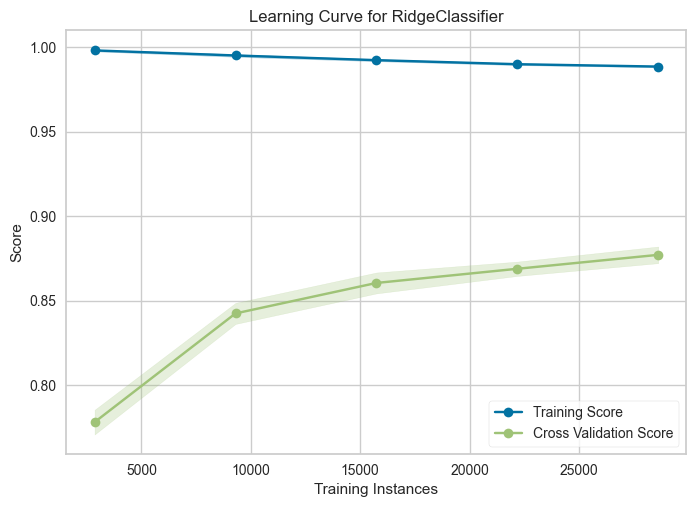

CPU times: user 40.3 s, sys: 224 ms, total: 40.5 s
Wall time: 20.2 s


In [46]:
%%time
visualizer = LearningCurve(best_model, scoring='accuracy').fit(X, y).show()

Но тут возникает проблема – переобучение, её мы будем убирать при помощи регуляризации и оптимизации параметров

### 3.10 Результаты и выводы

In [47]:
df_models

name     score       time
0         RidgeClassifier  0.863213   4.343041
1           SGDClassifier  0.861210   1.846391
2               LinearSVC  0.858973   3.236562
3            ComplementNB  0.857203   1.665176
4      LogisticRegression  0.839499  28.785666
5           MultinomialNB  0.826500   1.641961
6    KNeighborsClassifier  0.800084   7.710919
7  RandomForestClassifier  0.793747  24.750768

Судя по датафрейму, мы получили хорошие результаты для классификации по 13 классам. К слову, некоторые стандартные модели отсутствуют в списке по причине очень долгого обучения и низких метрик, к примеру: `MLPClassifier`, `GradientBoostingClassifier`, `SVC` и т.п.

## <hr>Глава 4. Улучшение и усовершенствование моделей

### 4.1 Выбор нескольких наиболее перспективных моделей на основе полученных результатов

Исходя из проведённых тестов, можно выделить несколько моделей, которые очнь хорошо себя показали

Ими являются:
* `RidgeClassifier`
* `SGDClassifier`
* `LinearSVC`

Так как все модели обучаются довольно быстро, следующим шагом можно найти оптимальные гиперпараметры для каждой

### 4.2 Применение Grid Search и поиск оптимальных гиперпараметров

### • RidgeClassifier

Для начала оценим стандартную модель

In [145]:
model, score = fit_model(RidgeClassifier())
print(f'{model[1].__class__.__name__}: {score:.4f}')

RidgeClassifier: 0.8732


Теперь создадим функцию для поиска оптимальных гиперпараметров

In [146]:
def objective(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 1e-2, 8, log=True),
        'tol': trial.suggest_float('tol', 1e-5, 1e-1, log=True),
        'solver': trial.suggest_categorical('solver', ['auto', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
        'max_iter': 5000,
    }

    if params['solver'] in ['svd', 'saga', 'cholesky']:
        params['fit_intercept'] = False

    model = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)),
        ('model', RidgeClassifier(**params)),
    ])

    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy').mean()
    
    return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

In [148]:
study.best_value, study.best_params

(0.8640979734885612,
 {'alpha': 1.6526669725627723, 'tol': 1.4866286517737427e-05, 'solver': 'sag'})

In [149]:
model, score_2 = fit_model(RidgeClassifier(**study.best_params))
print(f'{model[1].__class__.__name__}: {score_2:.4f}\nOld: {score:.4f}')

RidgeClassifier: 0.8706


### • SGDClassifier

In [150]:
model, score = fit_model(SGDClassifier())
print(f'{model[1].__class__.__name__}: {score:.4f}')

SGDClassifier: 0.8661


In [151]:
def objective(trial):
    params = {
        'loss': trial.suggest_categorical('loss', ['log_loss', 'huber', 'modified_huber', 'epsilon_insensitive', 'hinge', 'perceptron']),
        'alpha': trial.suggest_float('alpha', 1e-6, 8, log=True),
        'penalty': trial.suggest_categorical('penalty', ['elasticnet', 'l1', 'l2']),
        'l1_ratio': trial.suggest_float('l1_ratio', 0, 1),
        'max_iter': 10000
    }

    model = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)),
        ('model', SGDClassifier(**params)),
    ])

    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy').mean()
    
    return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

In [153]:
study.best_value, study.best_params

(0.856690294718922,
 {'loss': 'hinge',
  'alpha': 3.864688176018592e-05,
  'penalty': 'elasticnet',
  'l1_ratio': 0.3361793206046281})

In [154]:
model, score_2 = fit_model(SGDClassifier(**study.best_params))
print(f'{model[1].__class__.__name__}: {score_2:.4f}\nOld: {score:.4f}')

SGDClassifier: 0.8626


### • LinearSVC

In [155]:
model, score = fit_model(LinearSVC(max_iter=10000, dual='auto'))
print(f'{model[1].__class__.__name__}: {score:.4f}')

LinearSVC: 0.8678


In [166]:
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 1e-5, 8, log=True),
        'tol': trial.suggest_float('tol', 1e-5, 1e-1, log=True),
        'dual': trial.suggest_categorical('dual', [True, False]),
        'max_iter': 20000,
    }
    
    model = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)),
        ('model', LinearSVC(**params)),
    ])

    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy').mean()
    
    return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

In [168]:
study.best_value, study.best_params

(0.861815122431041,
 {'C': 0.3102862346384816, 'tol': 0.013027627289607236, 'dual': True})

In [170]:
model, score_2 = fit_model(LinearSVC(**study.best_params))
print(f'{model[1].__class__.__name__}: {score_2:.4f}\nOld: {score:.4f}')

LinearSVC: 0.8699
Old: 0.8678


### 4.3 Результаты и выводы

Как видно из результатов поиск параметров почти не увеличил точность лучших моделей. Возможно стоит рассмотреть модели с применением нейронных сетей и различных способов векторизации текста.

## <hr>Глава 5. Финальные результаты

## <hr>Заключение
* (Согласуется с введением и кратко рассказывает о том, какие задачи решены и каким образом)
* Список использованных источников (не менее 20)
* Приложения (обычно программный код, интерфейс, акты о внедрении...)

## <hr>Ссылки

https://blog.skillfactory.ru/glossary/nlp/

https://huggingface.co/models

https://huggingface.co/learn/nlp-course/ru/chapter7/1?fw=pt

https://habr.com/ru/articles/778048/